In [1]:
import numpy as  np
import pandas as pd
import matplotlib.pyplot as plt
# from scipy.io import wavfile
import os
import seaborn as sns
import random
import IPython.display
import librosa
from sklearn.model_selection import train_test_split
import torchaudio.transforms as transforms
# import torchaudio
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
import tensorflow.keras.layers as L

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D,Flatten, BatchNormalization, AveragePooling2D, Dense, Activation, Add 
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1_l2

from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.python.keras import backend as K

In [2]:
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 6} )
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)

In [2]:
audios = []
labels = []
audio_files = os.listdir('Crema')
for file in audio_files:
    labels.append(file.split('_')[2])
    # fs,data = wavfile.read(os.path.join('Crema',file))
    data, fs = librosa.load(os.path.join('Crema',file),sr=None)
    audios.append([data,fs])
    

In [3]:
print(len(labels))
print(len(audios))

7442
7442


In [4]:
set(labels)

{'ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD'}

In [5]:
fs_list = [x for _,x in audios]
set(fs_list) # all files have a sample rate of 16kHz

{16000}

,data,label
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",ANG
1,"[[0.00091552734, 0.0013122559, 0.0015869141, 0...",DIS
2,"[[0.008026123, 0.008453369, 0.008361816, 0.007...",FEA
3,"[[-0.004333496, -0.0032653809, -0.0030212402, ...",HAP
4,"[[0.0024108887, 0.001373291, 0.0013122559, 0.0...",NEU
...,...,...
7437,"[[0.00091552734, 0.0014038086, 0.001373291, 0....",DIS
7438,"[[-0.006958008, -0.0067749023, -0.0072021484, ...",FEA
7439,"[[-0.0022583008, -0.0018615723, -0.002319336, ...",HAP
7440,"[[-0.0016174316, -0.0010681152, -0.00076293945...",NEU


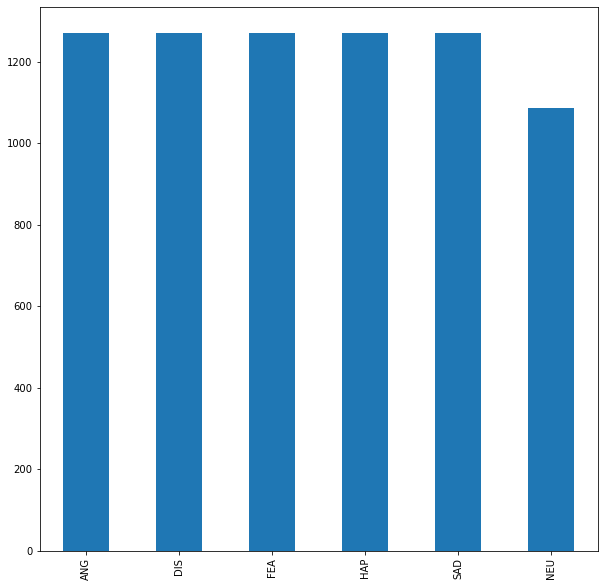

In [6]:
df = pd.concat([pd.Series(audios,name='data'),pd.Series(labels,name='label')],axis=1)
df['label'].value_counts().plot(kind='bar',figsize=(10,10))
df

In [7]:
labels[5]

'SAD'

In [8]:
emotions = {'ANG':'Angry','SAD':'Sad','NEU':'Neutral','HAP':'Happy','FEA':'Fear','DIS':'Disgust'}
colors = {'ANG':'red','SAD':'navy','NEU':'black','HAP':'yellow','FEA':'purple','DIS':'green'}

def load_audio(df,emotion):

    audios = list(df[df['label'] == emotion]['data'])
    idx = random.randint(0,len(audios)-1) # choosing a random file of that emotion
    audio = audios[idx][0]
    fs = audios[idx][1]
    duration = len(audio)/fs

    time = np.arange(0,duration,1/fs) # time vector

    plt.figure(figsize=(16,8))
    plt.plot(time,audio,color=colors[emotion])
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(emotions[emotion] + ' Waveform')
    plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
    plt.show()
    return audio, fs

In [9]:
def create_spectrogram(data, fs, emotion):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(emotion), size=15)
    librosa.display.specshow(Xdb, sr=fs, x_axis='time', y_axis='hz')
    plt.colorbar()

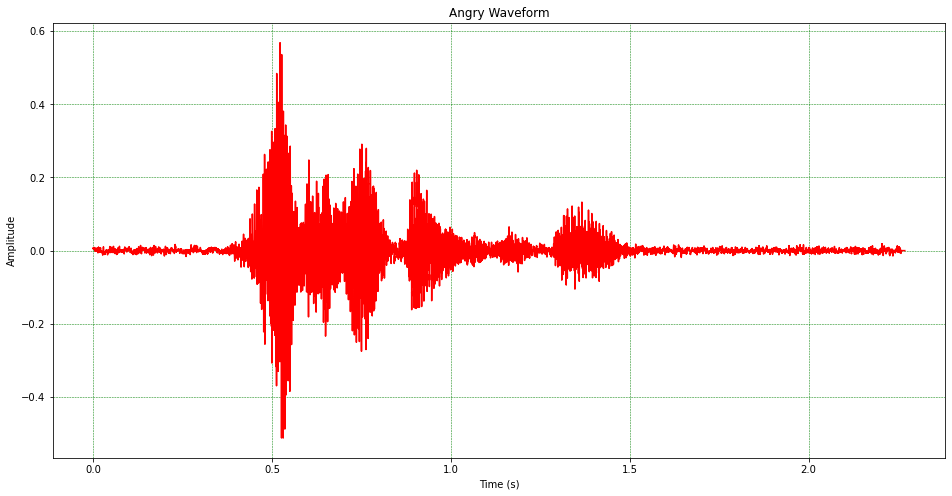

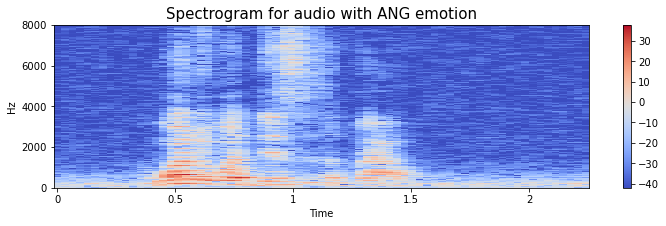

In [10]:
# ANGRY
audio,fs = load_audio(df,'ANG')
create_spectrogram(audio,fs,'ANG')
IPython.display.Audio(audio,rate=fs)


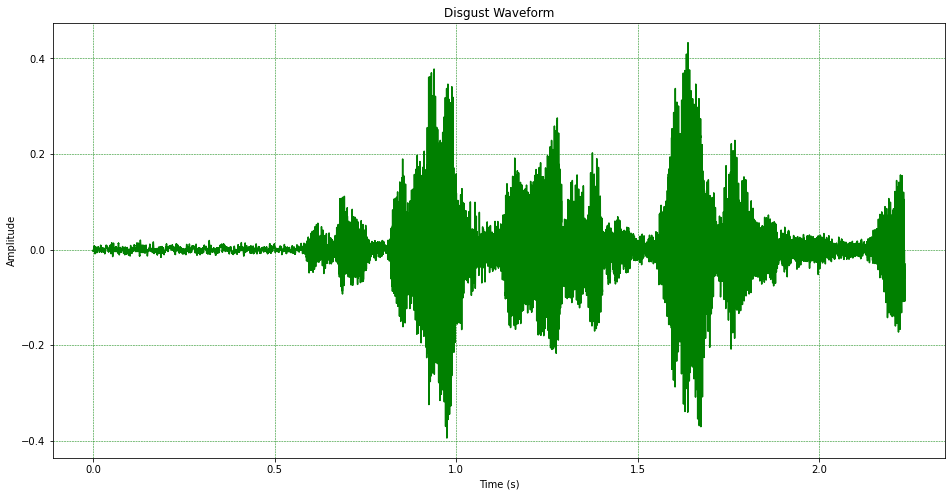

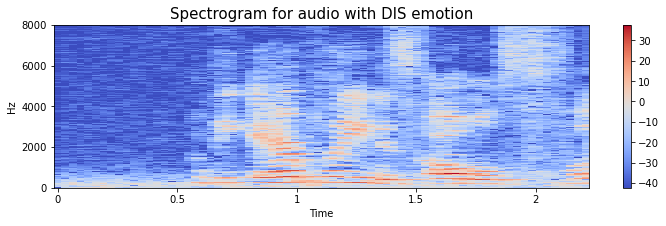

In [11]:
# DISGUSTED 
audio,fs = load_audio(df,'DIS')
create_spectrogram(audio,fs,'DIS')
IPython.display.Audio(audio,rate=fs)


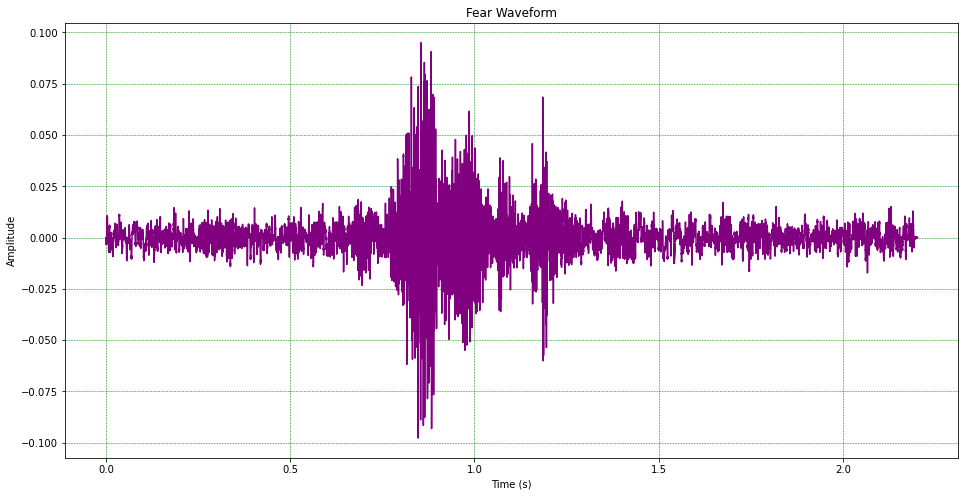

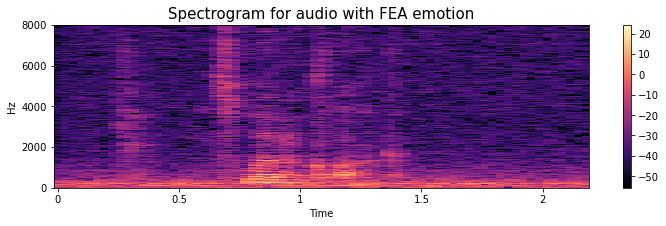

In [12]:
# FEAR
audio,fs = load_audio(df,'FEA')
create_spectrogram(audio,fs,'FEA')
IPython.display.Audio(audio,rate=fs)


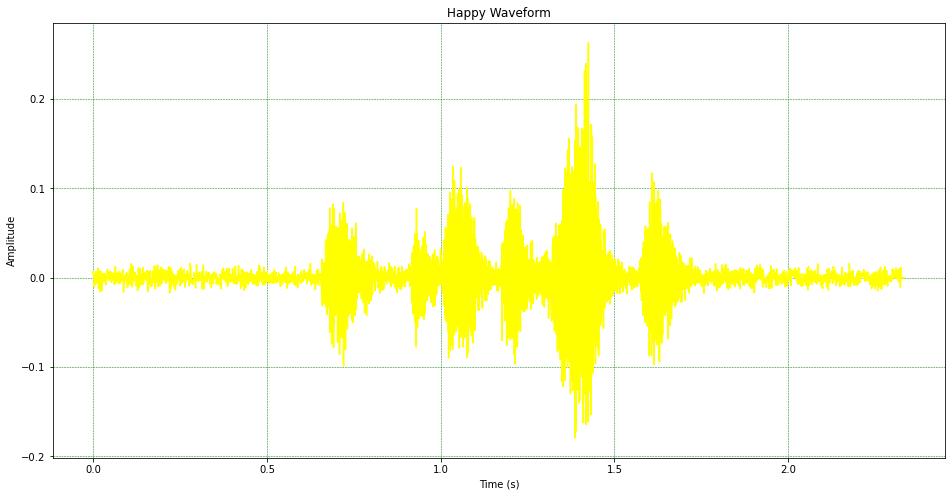

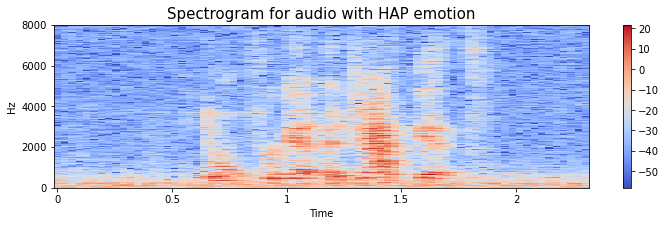

In [13]:
# HAPPY
audio,fs = load_audio(df,'HAP')
create_spectrogram(audio,fs,'HAP')
IPython.display.Audio(audio,rate=fs)


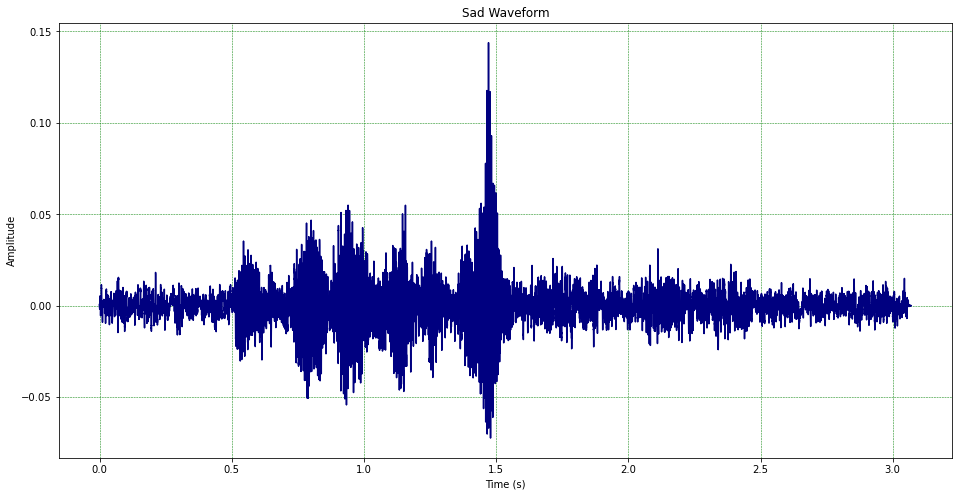

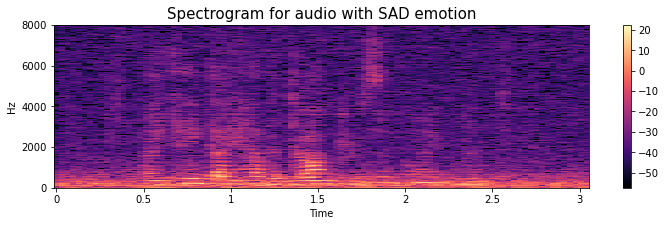

In [14]:
# SAD
audio,fs = load_audio(df,'SAD')
create_spectrogram(audio,fs,'SAD')
IPython.display.Audio(audio,rate=fs)

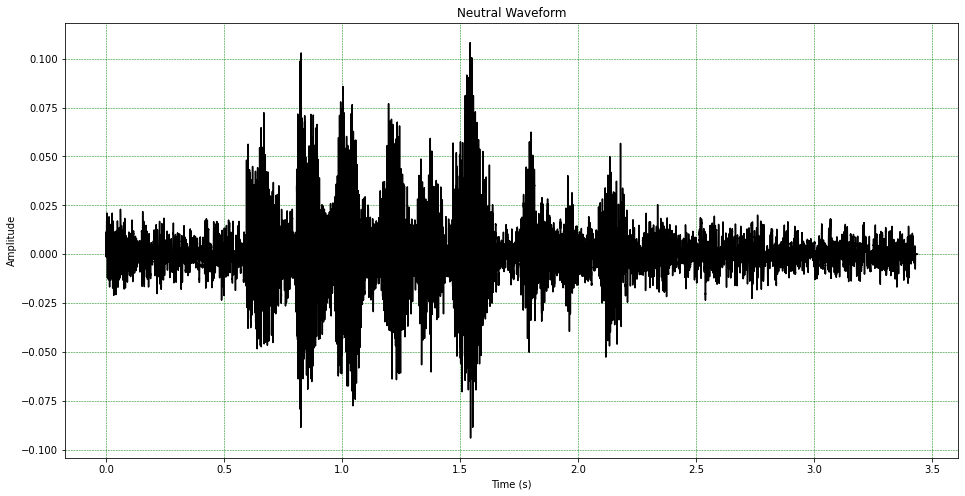

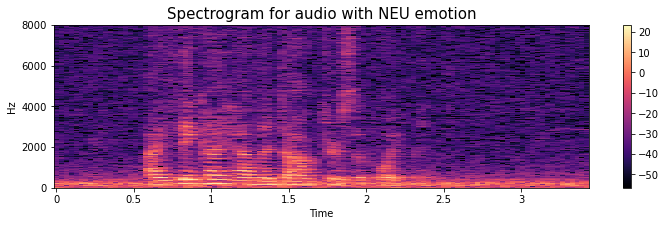

In [15]:
# NEUTRAL
audio,fs = load_audio(df,'NEU')
create_spectrogram(audio,fs,'NEU')
IPython.display.Audio(audio,rate=fs)


In [186]:
def pad(list,mel_spectrogram=False,max_len=None):
    padded_list = []
    if not mel_spectrogram:
        if max_len == None:
            max_len =  max([i.size for i in list])
        for l in list:
            if not l.size >= max_len:
                padded_list.append(np.pad(l, (0, max_len-l.size), 'constant'))
            else:
                padded_list.append(l[:max_len])
    else:
        if max_len == None:
            max_len =  max([i.shape[0] for i in list])
        for l in list:
            if not l.shape[0] == max_len:
                padded_list.append(np.pad(l, [(0, max_len-l.shape[0]),(0,0)], mode='constant'))
            else:
                padded_list.append(l[:max_len,:])
    return padded_list,max_len


In [108]:
df.to_numpy().shape

(7442, 2)

In [109]:
df['data'][2][0].shape

(34701,)

In [110]:
audio = df['data'][0][0]
fs = df['data'][0][1]
mel = librosa.feature.melspectrogram(y=audio, sr=fs, n_fft=1024,n_mels=128).T
mel_db = librosa.power_to_db(mel, ref=np.max)
mel.shape

(72, 128)

In [178]:
for data,fs in df['data'].to_numpy():
    print(data)

[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 6.1035156e-05 0.0000000e+00
 0.0000000e+00]
[ 9.1552734e-04  1.3122559e-03  1.5869141e-03 ... -3.0517578e-05
  0.0000000e+00  0.0000000e+00]
[ 8.0261230e-03  8.4533691e-03  8.3618164e-03 ... -9.1552734e-05
 -9.1552734e-05 -3.0517578e-05]
[-0.0043335  -0.00326538 -0.00302124 ... -0.00012207 -0.00018311
 -0.00021362]
[ 0.00241089  0.00137329  0.00131226 ... -0.00036621 -0.00054932
 -0.00024414]
[0.0027771  0.00241089 0.00234985 ... 0.         0.         0.        ]
[-3.0517578e-05 -6.4086914e-04  3.0517578e-04 ... -6.1035156e-05
  9.1552734e-05  0.0000000e+00]
[-0.00143433  0.00027466  0.00064087 ...  0.          0.
  0.        ]
[0.00338745 0.00366211 0.0038147  ... 0.         0.         0.        ]
[ 6.7443848e-03  6.1645508e-03  4.7607422e-03 ... -3.0517578e-05
 -3.0517578e-05 -3.0517578e-05]
[-0.00228882 -0.00204468 -0.00180054 ...  0.          0.
  0.        ]
[0.00585938 0.00494385 0.00592041 ... 0.         0.         0.        ]
[-0.0

In [168]:
X = np.array([x for x,_ in df['data']],dtype=object) 
X[0]

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 6.1035156e-05,
       0.0000000e+00, 0.0000000e+00], dtype=float32)

In [179]:
X_trainval, X_test, y_trainval, y_test = train_test_split(df['data'].to_numpy(), np.array(labels), test_size=0.3, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.05, random_state=42,stratify=y_trainval)

In [180]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

In [181]:
y_val.shape

(261,)

In [183]:
X_train.shape[0]

4948

In [194]:
for data in X_train:
    print(data)

[array([-0.00479126, -0.00527954, -0.00588989, ..., -0.00085449,
       -0.00085449, -0.00085449], dtype=float32), 16000]
[array([-2.1057129e-03, -1.2512207e-03, -1.6784668e-03, ...,
        0.0000000e+00,  3.0517578e-05,  0.0000000e+00], dtype=float32), 16000]
[array([ 8.0261230e-03,  7.5683594e-03,  7.1105957e-03, ...,
       -3.0517578e-05,  0.0000000e+00,  3.0517578e-05], dtype=float32), 16000]
[array([0.00241089, 0.00216675, 0.00234985, ..., 0.        , 0.        ,
       0.        ], dtype=float32), 16000]
[array([-0.00061035, -0.00067139, -0.00167847, ..., -0.00021362,
       -0.00030518, -0.00042725], dtype=float32), 16000]
[array([-0.00604248, -0.00534058, -0.0055542 , ...,  0.        ,
        0.        ,  0.        ], dtype=float32), 16000]
[array([-0.00296021, -0.00415039, -0.0039978 , ..., -0.00039673,
        0.00024414,  0.        ], dtype=float32), 16000]
[array([0.01077271, 0.00976562, 0.0090332 , ..., 0.00033569, 0.00036621,
       0.00039673], dtype=float32), 16000]


In [195]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
def create_feature_space(X,y=None,mel_spectrogram=False,training = False, max_len_zcr=None,max_len_en=None,max_len_mfccs=None,max_len_mel=None,clf=None,mean=None,stddev=None):
    # labels = []
    if not mel_spectrogram: # time/freq domain feature space
        feature_space = []
        zcrs=[]
        energies=[]
        mfccs=[]
        rolloff=[]
        # lfccs = []
        # transform = transforms.LFCC(
        # speckwargs={"n_fft": 400, "hop_length": 512, "center": False})
        for i,data in enumerate(X):
            # audio = np.array(data[0][0],dtype='float')
            audio = data[0]
            fs = data[1]
            # zero_crosses = np.nonzero(np.diff(audio > 0))[0]
            # zcr = zero_crosses.size/len(audio) # zero crossing rate

            # zero crossing rate
            zcr=np.squeeze(librosa.feature.zero_crossing_rate(audio,frame_length=2048,hop_length=128))
            # print(zcr.shape)
            zcrs.append(zcr)

            # normalized energy
            # energy=np.squeeze(librosa.feature.rms(audio,frame_length=2048,hop_length=128))
            energy = np.array([sum(audio[j:j+2048]**2)/2048 for j in range(0, len(audio), 128)])
            # print(energy.shape)
            energies.append(energy)

            # mel frequency cepstral coefficient (MFCC)
            mfcc=np.ravel(librosa.feature.mfcc(y=audio,sr=fs).T)
            # print(mfcc.shape)
            mfccs.append(mfcc)

            roll = np.squeeze(librosa.feature.spectral_rolloff(y=audio, sr=fs,hop_length=128))
            rolloff.append(roll)
            
            # lfcc = transform(tf.convert_to_tensor(audio)[0])
            # lfccs.append(lfcc.numpy())
            
            # feature_space.append(np.concatenate((zcr,energy,mfcc), axis=None))
            # labels.append(data[1])

            if i%1000==0:
                print(f'audio #{i} checkpoint')

        # max_len = max([len(i) for i in zcrs]) # find the longest list of scr to pad the others until they have equal length
        if not training:
            zcrs,_ = pad(zcrs,max_len=max_len_zcr)
            energies,_ = pad(energies,max_len=max_len_en)
            mfccs,_ = pad(mfccs,max_len=max_len_mfccs)
        else:
            zcrs,max_len_z = pad(zcrs)
            energies,max_len_e = pad(energies)
            mfccs,max_len_m = pad(mfccs)

        # lfccs = pad(lfccs)

        for i in range(X.shape[0]):
            # feature_space.append(np.concatenate((zcrs[i],energies[i],mfccs[i],lfccs[i]), axis=None))
            feature_space.append(np.concatenate((zcrs[i],energies[i],mfccs[i],rolloff[i]), axis=None))

        # labels = np.array(labels)
        feature_space = np.array(feature_space)
        if training:
            clf = LinearDiscriminantAnalysis(n_components=5).fit(feature_space,y)
            feature_space=clf.transform(feature_space)
            return feature_space,max_len_z,max_len_e,max_len_m,clf
        else:
            feature_space=clf.transform(feature_space)
            return feature_space
    else:
        mels=[]
        for i,data in enumerate(X):
            audio = data[0]
            fs = data[1]
            mel = librosa.feature.melspectrogram(y=audio, sr=fs, n_fft=2048,n_mels=128).T
            # mel = librosa.feature.melspectrogram(y=audio, sr=fs, n_fft=1024,n_mels=128)
            mel_db = librosa.power_to_db(mel, ref=np.max)
            mels.append(mel_db)
            # labels.append(data[1])
            if i%1000==0:
                print(f'audio #{i} checkpoint')
        if training:
            mels,max_len_mels = pad(mels,mel_spectrogram=True)
            mels=np.array(mels)
            mean_value = np.mean(mels)
            std_value = np.std(mels)
            norm_mels = (mels - mean_value) / std_value
            return norm_mels,max_len_mels,mean_value,std_value
        else:
            mels,_ = pad(mels,mel_spectrogram=True,max_len=max_len_mel)
            norm_mels = (mels - mean) / stddev
            return norm_mels



In [196]:
space,z,e,m,clf = create_feature_space(X_train,y=y_train,training=True)

audio #0 checkpoint
audio #1000 checkpoint
audio #2000 checkpoint
audio #3000 checkpoint
audio #4000 checkpoint


In [198]:
space_val = create_feature_space(X_val,max_len_zcr=z,max_len_en=e,max_len_mfccs=m,clf=clf)
space_test = create_feature_space(X_test,max_len_zcr=z,max_len_en=e,max_len_mfccs=m,clf=clf)

audio #0 checkpoint
audio #0 checkpoint
audio #1000 checkpoint
audio #2000 checkpoint


In [197]:
space.shape

(4948, 5)

In [199]:
space_test.shape

(2233, 5)

In [201]:
X_test.shape

(2233,)

In [202]:
X_val.shape

(261,)

In [203]:
space_val.shape

(261, 5)

In [204]:
y_val.shape

(261,)

In [205]:
X_train = space
X_test = space_test
X_val = space_val

In [ ]:
mels, mel_len,mean,stddev = create_feature_space(X_train,training=True,mel_spectrogram=True)

In [ ]:
mels_test = create_feature_space(X_test,mel_spectrogram=True,max_len_mel=mel_len,mean=mean,stddev=stddev)
mels_val = create_feature_space(X_val,mel_spectrogram=True,max_len_mel=mel_len,mean=mean,stddev=stddev)

In [112]:
# mels,labels2 =create_feature_space(df,mel_spectrogram=True)

audio #0 checkpoint
audio #1000 checkpoint
audio #2000 checkpoint
audio #3000 checkpoint
audio #4000 checkpoint
audio #5000 checkpoint
audio #6000 checkpoint
audio #7000 checkpoint


In [115]:
# len(labels2)

7442

In [116]:
mels[1].shape

(157, 128)

In [40]:
# le = LabelEncoder()
# labels1 = le.fit_transform(labels1)
# labels1


array([0, 1, 2, ..., 3, 4, 5], dtype=int64)

In [117]:
# le = LabelEncoder()
# labels2 = le.fit_transform(labels2)
# labels2


array([0, 1, 2, ..., 3, 4, 5], dtype=int64)

In [42]:
# np.count_nonzero(labels1==labels2) #;))))))))))))

7442

In [43]:
# len(labels)

7442

In [119]:
# len(space)
mels[0].shape

(157, 128)

In [118]:
mels = np.array(mels)
# labels2.shape

(7442,)

In [120]:
mels.shape

(7442, 157, 128)

In [121]:
# X_trainval, X_test, y_trainval, y_test = train_test_split(mels, labels2, test_size=0.3, random_state=42,stratify=labels2)


In [88]:
# X_trainval, X_test, y_trainval, y_test = train_test_split(space, labels1, test_size=0.3, random_state=42,stratify=labels1)

In [122]:
# X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.05, random_state=42,stratify=y_trainval)

In [206]:
len(X_train)

4948

In [42]:
# ss=StandardScaler()
# X_train=ss.fit_transform(X_train)
# X_test=ss.transform(X_test)
# X_val=ss.transform(X_val)

In [207]:
earlystopper = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1, monitor='val_acc')
checkpointer = tf.keras.callbacks.ModelCheckpoint('models\\first_model.h5', verbose=1, monitor='val_acc',mode='max', save_best_only=True)
# checkpointer = tf.keras.callbacks.ModelCheckpoint('models\\first_model.h5', verbose=1, save_best_only=True)

    

In [208]:
y_train.shape

(4948,)

In [168]:
# hist = resnett34.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_data=(X_val, y_val), callbacks = [earlystopper, checkpointer])

Epoch 1/50
39/39 [==============================] - ETA: 0s - loss: 2.8418 - acc: 0.2292 
Epoch 1: val_loss improved from inf to 2659.51025, saving model to models\first_model.h5
39/39 [==============================] - 590s 15s/step - loss: 2.8418 - acc: 0.2292 - val_loss: 2659.5103 - val_acc: 0.2912
Epoch 2/50
39/39 [==============================] - ETA: 0s - loss: 1.6705 - acc: 0.3042 
Epoch 2: val_loss improved from 2659.51025 to 5.52797, saving model to models\first_model.h5
39/39 [==============================] - 571s 15s/step - loss: 1.6705 - acc: 0.3042 - val_loss: 5.5280 - val_acc: 0.3103
Epoch 3/50
39/39 [==============================] - ETA: 0s - loss: 1.5451 - acc: 0.3686 
Epoch 3: val_loss improved from 5.52797 to 1.75095, saving model to models\first_model.h5
39/39 [==============================] - 569s 15s/step - loss: 1.5451 - acc: 0.3686 - val_loss: 1.7509 - val_acc: 0.2835
Epoch 4/50
39/39 [==============================] - ETA: 0s - loss: 1.4473 - acc: 0.4093 
Ep

In [209]:
X_train.shape

(4948, 5)

In [210]:
y_train

array([0, 5, 2, ..., 0, 1, 3], dtype=int64)

In [88]:
# X_train = np.array(X_train)
# X_val = np.array(X_val)
# y_train = np.array(y_train)
# y_val = np.array(y_val)


In [211]:
# X_train = np.expand_dims(X_train,axis=2)
X_train.shape

(4948, 5)

In [212]:
# X_val = np.expand_dims(X_val,axis=2)
X_val.shape

(261, 5)

In [213]:
# y_train = y_train.reshape(-1,1)
y_train.shape

(4948,)

In [214]:
# y_val = y_val.reshape(-1,1)
y_val.shape

(261,)

In [227]:
# x_input = tf.keras.layers.Input((157,157,1))
# x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
model=tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    L.Flatten(),
    L.Dropout(rate=0.2),

    L.Dense(512,activation='relu'),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(6,activation='softmax')
])
# model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='acc')
model.summary()



Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_52 (Conv1D)          (None, 5, 512)            3072      
                                                                 
 batch_normalization_163 (Ba  (None, 5, 512)           2048      
 tchNormalization)                                               
                                                                 
 max_pooling1d_52 (MaxPoolin  (None, 3, 512)           0         
 g1D)                                                            
                                                                 
 conv1d_53 (Conv1D)          (None, 3, 512)            1311232   
                                                                 
 batch_normalization_164 (Ba  (None, 3, 512)           2048      
 tchNormalization)                                               
                                                     

In [228]:
hist = model.fit(X_train, y_train, batch_size=64, epochs=100, verbose=1, validation_data=(X_val, y_val), callbacks = [checkpointer])

Epoch 1/100
78/78 [==============================] - ETA: 0s - loss: 0.4926 - acc: 0.8551
Epoch 1: val_acc did not improve from 0.27586
78/78 [==============================] - 24s 254ms/step - loss: 0.4926 - acc: 0.8551 - val_loss: 3.8214 - val_acc: 0.1992
Epoch 2/100
78/78 [==============================] - ETA: 0s - loss: 0.2620 - acc: 0.9216
Epoch 2: val_acc did not improve from 0.27586
78/78 [==============================] - 20s 263ms/step - loss: 0.2620 - acc: 0.9216 - val_loss: 6.1860 - val_acc: 0.2222
Epoch 3/100
78/78 [==============================] - ETA: 0s - loss: 0.2245 - acc: 0.9301
Epoch 3: val_acc did not improve from 0.27586
78/78 [==============================] - 21s 266ms/step - loss: 0.2245 - acc: 0.9301 - val_loss: 12.2101 - val_acc: 0.2184
Epoch 4/100
78/78 [==============================] - ETA: 0s - loss: 0.2144 - acc: 0.9329
Epoch 4: val_acc did not improve from 0.27586
78/78 [==============================] - 19s 238ms/step - loss: 0.2144 - acc: 0.9329 - va

In [124]:
print(model.evaluate(X_test,y_test))

70/70 [==============================] - 1s 7ms/step - loss: 0.9139 - accuracy: 0.7971
[0.9138697981834412, 0.7971339225769043]


In [125]:
y_val[0]

5

In [126]:
X_train.shape

(4948, 5)

In [127]:
# predicting on test data.
yhat = model.predict(X_test)
classes_pred=np.argmax(yhat,axis=1)
# y_pred = encoder.inverse_transform(pred_test)

# y_test = encoder.inverse_transform(y_test)
classes_pred

70/70 [==============================] - 1s 6ms/step


array([5, 5, 0, ..., 4, 0, 5], dtype=int64)

In [128]:
y_test

array([5, 5, 0, ..., 4, 0, 5], dtype=int64)

In [129]:
classes_pred.shape

(2233,)

In [130]:
accuracy = np.count_nonzero(y_test == classes_pred)/y_test.shape[0]
accuracy

0.7971339005821765

In [124]:
X_train.shape

(4948, 157, 128)

In [128]:
model2D=tf.keras.Sequential([
    L.Conv2D(32,kernel_size=5, strides=1,padding='same', activation='relu',kernel_regularizer=l1_l2(l1=0.01, l2=0.01),input_shape=(X_train.shape[1],X_train.shape[2],1)),
    L.BatchNormalization(),
    L.MaxPool2D(pool_size=5,strides=2,padding='same'),
    L.Conv2D(64,kernel_size=5,strides=1,padding='same',activation='relu',kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
    L.BatchNormalization(),
    L.MaxPool2D(pool_size=5,strides=2,padding='same'),
    # L.Conv2D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.Conv2D(128,kernel_size=5,strides=1,padding='same',activation='relu',kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
    L.BatchNormalization(),
    L.MaxPool2D(pool_size=3,strides=2,padding='same'),
    L.Conv2D(128,kernel_size=5,strides=1,padding='same',activation='relu',kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
    # L.BatchNormalization(),
    # L.MaxPool2D(pool_size=3,strides=2,padding='same'),

    # L.Conv2D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    # L.BatchNormalization(),
    # L.MaxPool2D(pool_size=5,strides=2,padding='same'),
    # L.Conv2D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    # L.BatchNormalization(),
    # L.GlobalAveragePooling2D(),

    
    L.Flatten(),
    # L.Dropout(rate=0.1),
    # L.Dense(512,activation='relu'),
    L.Dense(128,activation='relu'),
    # L.BatchNormalization(),
    L.Dense(64,activation='relu'),
    # L.BatchNormalization(),
    L.Dense(6,activation='softmax')
])
# model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
model2D.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='acc')
model2D.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_93 (Conv2D)          (None, 157, 128, 16)      416       
                                                                 
 batch_normalization_100 (Ba  (None, 157, 128, 16)     64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_71 (MaxPoolin  (None, 79, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_94 (Conv2D)          (None, 79, 64, 32)        12832     
                                                                 
 batch_normalization_101 (Ba  (None, 79, 64, 32)       128       
 tchNormalization)                                               
                                                     

In [129]:
X_train.shape

(4948, 157, 128)

In [130]:
y_train.shape

(4948,)

In [131]:
X_val.shape

(261, 157, 128)

In [132]:
y_val.shape

(261,)

In [133]:
history = model2D.fit(X_train, y_train, batch_size=128, epochs=100, verbose=1, validation_data=(X_val, y_val), callbacks = [earlystopper, checkpointer])

Epoch 1/100
39/39 [==============================] - ETA: 0s - loss: 28.3329 - acc: 0.3072
Epoch 1: val_acc did not improve from 0.28352
39/39 [==============================] - 114s 3s/step - loss: 28.3329 - acc: 0.3072 - val_loss: 7.0806 - val_acc: 0.1686
Epoch 2/100
39/39 [==============================] - ETA: 0s - loss: 4.1660 - acc: 0.3464
Epoch 2: val_acc did not improve from 0.28352
39/39 [==============================] - 114s 3s/step - loss: 4.1660 - acc: 0.3464 - val_loss: 3.0828 - val_acc: 0.1724
Epoch 3/100
39/39 [==============================] - ETA: 0s - loss: 2.7129 - acc: 0.3472
Epoch 3: val_acc did not improve from 0.28352
39/39 [==============================] - 114s 3s/step - loss: 2.7129 - acc: 0.3472 - val_loss: 2.9572 - val_acc: 0.1724
Epoch 4/100
39/39 [==============================] - ETA: 0s - loss: 2.5847 - acc: 0.3575
Epoch 4: val_acc did not improve from 0.28352
39/39 [==============================] - 114s 3s/step - loss: 2.5847 - acc: 0.3575 - val_loss:

KeyboardInterrupt: 